# Rapids UMAP on Colab

# <img src="http://reconstrue.com/assets/images/reconstrue_logo_brandmark.svg" width="42px" align="top" /> **Reconstrue**

## Legal

This code is licensed by Reconstrue under the Apache 2.0 License.

Reconstrue's work on this started from notebooks in the Rapids' repo, [notebook-contrib](https://github.com/rapidsai/notebooks-contrib) which is licensed licensed under the [Apache License 2.0](https://github.com/rapidsai/notebooks-contrib/blob/branch-0.11/LICENSE). The following two files were used:
- [umap_demo.ipynb](https://github.com/rapidsai/notebooks-contrib/blob/branch-0.11/colab_notebooks/cuml/umap_demo.ipynb)
- [09_Introduction_to_Dimensionality_Reduction.ipynb](https://github.com/rapidsai/notebooks-contrib/blob/branch-0.11/getting_started_notebooks/intro_tutorials/09_Introduction_to_Dimensionality_Reduction.ipynb)

## Introduction

This notebook exercises Rapids' GPU accelerated UMAP implementation, on Colab. This is just a proof of concept test drive, nothing single-cell specific, nor large datasets. 


## Detect GPU

On Colab, you have to explicitly request a GPU. As of late 2019, there are four that have been seen recently.

These work with Rapids:
- Tesla P100
- Tesla T4

These do not:
- Tesla P4
- Tesla K80

Check to maker sure a compatible GPU has been allocated (after, of course, being requested).

In [0]:
# This cell's code works on Colab, but a more elegant way to do the same is !nvidia-smi
# Former is JSON, latter is ASCII table which is easy to in an cell's output.

#from tensorflow.python.client import device_lib
#
# First let's ask for TF 2.x, not 1.x
#try:
#  # %tensorflow_version is a Colab-only thing 
#  %tensorflow_version 2.x
#except Exception:
#  print("TensorFlow 2.x does not seem to be available")
#device_lib.list_local_devices()

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.46.207.106:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 11943690795926729460),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9250738211238841024),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16912749527550229882),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12721892383075163732),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2478466916789124215),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13852741638622652764),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 7785270478890414614),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4555359326404293607),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 16854890683

Complaints of NVIDIA-SMI failing to communicate with NVIDIA driver means there is no GPU. A GPU can be requested in the `Runtime` menu via 'Change runtime type'.


## Colab's pre-installed UMAP

The stock UMAP implementation, package umap-learn, comes preinstalled on Colab.

This version is already fast because Numba is used.

| Run time | Runtime |
|--|--|
| 0:14:20 | CPU |
| 0:06:19 | K80 |
| **0:07:11** | TPU |

These tests were repeated a few times. Times were all within about 15 seconds of each other.

In [0]:
## Default Colab install of UMAP
!pip show umap-learn


Name: umap-learn
Version: 0.3.10
Summary: Uniform Manifold Approximation and Projection
Home-page: http://github.com/lmcinnes/umap
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, numpy, numba, scikit-learn
Required-by: lucid


### First test

Via [UMAP on the MNIST Digits dataset](https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_mnist_example.html#sphx-glr-auto-examples-plot-mnist-example-py)

Start time:  2019-12-07 12:21:00.723913



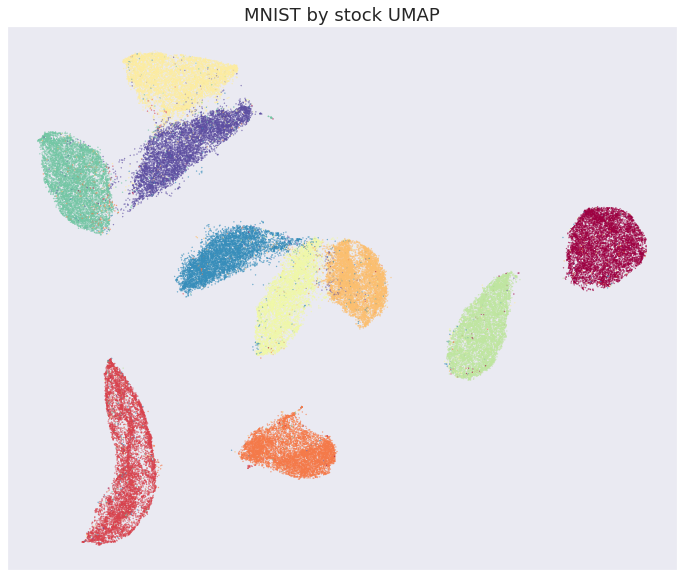

Run time: 0:07:11


In [3]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

sns.set(context="notebook", style="dark")

start_time = time.time()
print("Start time:  %s\n" % datetime.datetime.now())

mnist = fetch_openml('mnist_784', version=1)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(mnist.data)

fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST by stock UMAP", fontsize=18)

plt.show()

print("Run time: %s" % datetime.timedelta(seconds=round(time.time()-start_time)))


## Rapids UMAP

### cuML's UMAP docs

UMAP is a dimensionality reduction algorithm which performs non-linear dimension reduction. 
- It can also be used for visualization of the dataset. 

The UMAP model implemented in cuml allows the user to set the following parameter values:
1.	`n_neighbors`: number of neighboring samples used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved (default = 15)
2.	`n_components`: the dimension of the space to embed into (default = 2)
3.	`n_epochs`: number of training epochs to be used in optimizing the low dimensional embedding (default = None)
4.	`learning_rate`: initial learning rate for the embedding optimization (default = 1.0)
5.	`init`: the low dimensional embedding to use: a. 'spectral': use a spectral embedding of the fuzzy 1-skeleton b. 'random': assign initial embedding positions at random (default = 'spectral')
6.	`min_dist`: the minimum distance that should be present between embedded points (default = 0.1)
7.	`spread`: determines how clustered the embedded points will be (default = 1.0)
8.	`set_op_mix_ratio`: is the ratio of pure fuzzy union to intersection. If the value is 1.0 then it will be a pure fuzzy union and for the value of 0.0 it will be a pure fuzzy interpolation (default = 1.0)
9.	`local_connectivity`: number of nearest neighbors that should be assumed to be connected at a local level. It should be not more than the local intrinsic dimension of the manifold (default = 1)
10.	`repulsion_strength`: weighting applied to negative samples in low dimensional embedding optimization. Values > 1 implements a higher negative value to the samples (default = 1.0)
11.	`negative_sample_rate`: the rate at which the negative samples should be selected per positive sample during the optimization process (default = 5)
12.	`transform_queue_size`: embedding new points using a trained model_ will control how aggressively to search for nearest neighbors (default = 4.0)
13.	`verbose`: bool (default False)

The cuml implemetation of the UMAP model has the following functions that one can run:
1.	`fit`: it fits the dataset into an embedded space
2.	`fit_transform`: it fits the dataset into an embedded space and returns the transformed output
3.	`transform`: it transforms the dataset into an existing embedded space and returns the low dimensional output

The model accepts only numpy arrays or cudf dataframes as the input. 
- In order to convert your dataset to cudf format please read the cudf [documentation](https://rapidsai.github.io/projects/cudf/en/latest/) 
- For additional information on the UMAP model please refer to the cuml [UMAP documentation](https://rapidsai.github.io/projects/cuml/en/0.6.0/api.html#cuml.UMAP) 
- This setup may take a few minutes
- Long output (output display removed)

## Setup code environment

In [0]:
# TODO: Kill
# This was before Rapids 0.11
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

In [0]:
!wget -nc c
!bash rapids-colab.sh

import sys, os
dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
if os.path.exists('update_pyarrow.py'): ## Only exists if RAPIDS version is 0.11 or higher
  exec(open('update_pyarrow.py').read(), globals())

--2019-12-06 08:37:15--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5287 (5.2K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   5.16K  --.-KB/s    in 0s      

2019-12-06 08:37:15 (110 MB/s) - ‘rapids-colab.sh’ saved [5287/5287]

PLEASE READ
********************************************************************************************************
Colab v0.11+ Migration Notice:
 
There has been a NECESSARY Colab script code change for VERSION 0.11+ that MAY REQUIRE an update how you install RAPIDS into Colab!  
Not all Colab notebooks are updated (like personal Colabs) and while the script will install RAPIDS correctly, 
a necces

In [0]:
!ls
!rm rapids-colab.sh

sample_data
rm: cannot remove 'rapids-colab.sh': No such file or directory


In [0]:
!echo $RAPIDS_VERSION

### Installation completed bell
The above install can take a bit, and will have to be done once every 12 hours.

Here's a page with a list of free bells sounds: [Bell Sound Effects](https://www.soundjay.com/bell-sound-effect.html). One of those will do as an alert that the boring prelude is over.

In [0]:
import requests
import IPython

# bell_src_10_sec = "https://www.soundjay.com/misc/bell-ring-01.mp3"
bell_src = "https://www.soundjay.com/misc/bell-ringing-05.mp3"
bell_dest = "/content/bell.mp3"

response = requests.get(bell_src)
open(bell_dest, 'wb').write(response.content)

IPython.display.Audio(bell_dest, autoplay=True)


### Imports

In [0]:
import numpy as np
import pandas as pd

import cudf
import os

from sklearn import datasets
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.manifold.t_sne import trustworthiness

from cuml.manifold.umap import UMAP

@# Running cuml's UMAP model on blobs dataset

In [0]:
# create a blobs dataset with 500 samples and 10 features each
data, labels = datasets.make_blobs(
    n_samples=500, n_features=10, centers=5)

In [0]:
# using the cuml UMAP algorithm to reduce the features of the dataset and store
embedding = UMAP().fit_transform(data)

In [0]:
# calculate the score of the results obtained using cuml's algorithm and sklearn kmeans
score = adjusted_rand_score(labels,
            KMeans(5).fit_predict(embedding))
print(score) # should equal 1.0

## Exercise cuml's UMAP

In [0]:
# load the iris dataset from sklearn and extract the required information
iris = datasets.load_iris()
data = iris.data

In [0]:
# define the cuml UMAP model and use fit_transform function to obtain the low dimensional output of the input dataset
embedding = UMAP(
    n_neighbors=10, min_dist=0.01,  init="random"
).fit_transform(data)

In [0]:
# calculate the trust worthiness of the results obtaind from the cuml UMAP
trust = trustworthiness(iris.data, embedding, 10)
print(trust)

In [0]:
# create a selection variable which will have 75% True and 25% False values. The size of the selection variable is 150
iris_selection = np.random.choice(
    [True, False], 150, replace=True, p=[0.75, 0.25])
# create an iris dataset using the selection variable
data = iris.data[iris_selection]
print(data)

In [0]:
# create a cuml UMAP model 
fitter = UMAP(n_neighbors=10, min_dist=0.01, verbose=False)
# fit the data created the selection variable to the cuml UMAP model created (fitter)
fitter.fit(data)
# create a new iris dataset by inverting the values of the selection variable (ie. 75% False and 25% True values) 
new_data = iris.data[~iris_selection]
# transform the new data using the previously created embedded space
embedding = fitter.transform(new_data)

In [0]:
# calculate the trustworthiness score for the new data created (new_data)
trust = trustworthiness(new_data, embedding, 10)
print(trust)

And that's where the first notebook ended, without any viz :(

### Continuing to viz

In [0]:
# TODO: not working yet:

# embedding is the final thing produces int umap_demo.ipynb
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']
colors = ['tab:' + color for color in colors]

# create figure
figure = plt.figure()
axis = figure.add_subplot(111)

for i in range(10):
    mask = y == i
    axis.scatter(embedding[mask, 0], embedding[mask, 1], 
                 c=colors[i], label=str(i))
axis.set_title('UMAP (gpu)')

plt.legend()
plt.tight_layout()
plt.show()

## Stuff from Intro to DR notebook

Repo `rapidsai/notebooks-contrib` has [09_Introduction_to_Dimensionality_Reduction.ipynb](https://github.com/rapidsai/notebooks-contrib/blob/branch-0.11/getting_started_notebooks/intro_tutorials/09_Introduction_to_Dimensionality_Reduction.ipynb), which does have a viz or two.

First notice the distinct inports:
```
# umap_demo.ipynb
from cuml.manifold.umap import UMAP

# 09_Introduction_to_Dimensionality_Reduction.ipynb
from cuml import UMAP as UMAP_GPU

```

In [0]:
import numpy as np; print('NumPy Version:', np.__version__)
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.datasets import load_digits


digits = load_digits()
X, y = digits['data'], digits['target']
X, y = X.astype(np.float32), y.astype(np.float32)
print('X: ', X.shape, X.dtype, 'y: ', y.shape, y.dtype)

In [0]:
# create figure
import matplotlib.pyplot as plt
figure = plt.figure()
f, axes = plt.subplots(4, 4, figsize=(10, 10))

i = 0
for row in axes:
    for axis in row:
        axis.imshow(X[i].reshape(8, 8), cmap='gray')
        axis.set_title('Class: ' + str(int(y[i])))
        i += 1
    
plt.tight_layout()
plt.show()


In [0]:
X_df = pd.DataFrame(X)
X_df.columns = ['feature_' + str(i) for i in range(X_df.shape[1])]
X_cudf = cudf.DataFrame.from_pandas(X_df)

In [0]:
from cuml import UMAP as UMAP_GPU
umap_gpu = UMAP_GPU(n_neighbors=10, n_components=2)

In [0]:
components_gpu = umap_gpu.fit_transform(X_cudf).to_pandas().values
components_gpu

In [0]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']
colors = ['tab:' + color for color in colors]

# create figure
figure = plt.figure()
axis = figure.add_subplot(111)

for i in range(10):
    mask = y == i
    axis.scatter(components_gpu[mask, 0], components_gpu[mask, 1], 
                 c=colors[i], label=str(i))
axis.set_title('UMAP (gpu)')

plt.legend()
plt.tight_layout()
plt.show()